In [25]:
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [26]:
!ls ../itensor/timings_*.txt

ls: cannot access '../itensor/timings_*.txt': No such file or directory


In [27]:
file = "../itensor/old/timings_nthreads_1_conserve_False.txt"

In [28]:
def parse_itensor_output(filename):
    """Given a filename of a timing_*.txt file in ../itensor/, return `chis, timings`."""
    with open(filename, 'r') as f:
        lines = f.readlines()
    sweep_line = re.compile(r".*sweep (\d+) energy=(\S+)\s+maxlinkdim=(\d+) maxerr=\S+ time=(\S+)")
    last_n = 0
    last_chi = 0
    chis = []
    times = []
    current_times_avg = []
    for line in lines:
        sweep = sweep_line.match(line)
        if sweep:
            #print("matched ", line[:-1])
            n = int(sweep.group(1))
            chi = int(sweep.group(3))
            time = float(sweep.group(4))
            assert n == last_n + 1  # TODO: multiple results in one file?
            last_n = n
            if chi == last_chi:
                current_times_avg.append(time)
            else:
                if len(current_times_avg) > 0:
                    chis.append(last_chi)
                    times.append(np.mean(current_times_avg))
                last_chi = chi
                current_times_avg = [] # don't include timings of sweeps where chi changed
    if len(current_times_avg) > 0:
        chis.append(last_chi)
        times.append(np.mean(current_times_avg))
    return np.array(chis), np.array(times)

In [29]:
parse_itensor_output(file)

(array([ 32,  64, 128, 256, 384, 512, 768]),
 array([8.450000e-01, 3.659000e+00, 1.395600e+01, 8.368900e+01,
        2.400910e+02, 5.971350e+02, 2.550708e+03]))

In [30]:
for file in Path("../itensor/old/").glob("timings_*.txt"):
    print(file)
    print(parse_itensor_output(file))

../itensor/old/timings_nthreads_1_conserve_False.txt
(array([ 32,  64, 128, 256, 384, 512, 768]), array([8.450000e-01, 3.659000e+00, 1.395600e+01, 8.368900e+01,
       2.400910e+02, 5.971350e+02, 2.550708e+03]))
../itensor/old/timings_nthreads_1_conserve_True.txt
(array([  32,   64,  128,  256,  384,  512,  768, 1024, 1536, 2028]), array([1.876000e+00, 2.596000e+00, 5.075000e+00, 1.235700e+01,
       2.383800e+01, 4.068800e+01, 1.038820e+02, 2.264000e+02,
       8.882820e+02, 1.962583e+03]))
../itensor/old/timings_nthreads_4_conserve_False.txt
(array([ 32,  64, 128, 256, 384, 512, 768]), array([8.710000e-01, 3.476000e+00, 1.069300e+01, 4.822600e+01,
       1.240710e+02, 3.031920e+02, 1.599575e+03]))
../itensor/old/timings_nthreads_4_conserve_True.txt
(array([  32,   64,  128,  256,  384,  512,  768, 1024, 1536, 2028]), array([   2.064,    2.73 ,    5.573,   12.457,   22.175,   35.385,
         75.711,  163.616,  709.501, 1639.851]))


In [38]:
def read_itensor_output(filename, expected_header="# sweep maxlinkdim walltime"):
    """Given a filename of a timing_*.txt file in ../itensor/, return `chis, timings`."""
    with open(filename, 'r') as f:
        lines = f.readlines()
    header = lines.pop(0)[:-1] # without newline
    if header != expected_header:
        raise ValueError(f"unexpected header reading {filename}:\n"
                         f"expected {expected_header!r}, got {header}")
    last_n = 0
    last_chi = 0
    chis = []
    times = []
    current_times_avg = []
    last_walltime = 0.
    for line in lines:
        n, chi, walltime = line.split()
        n = int(n)
        chi = int(chi)
        walltime = float(walltime)
        assert n == last_n + 1  # TODO: multiple results in one file?
        last_n = n
        if chi == last_chi:
            current_times_avg.append(walltime - last_walltime)
        else:
            if len(current_times_avg) > 0:
                chis.append(last_chi)
                times.append(np.mean(current_times_avg))
            last_chi = chi
            current_times_avg = [] # don't include timings of sweeps where chi changed
        last_walltime = walltime
    if len(current_times_avg) > 0:
        chis.append(last_chi)
        times.append(np.mean(current_times_avg))
    return np.array(chis), np.array(times)

timings_nthreads_04_conserve_True.out
[  32   64  128  256  384  512  768 1024 1536] [  1.65357685   2.34210992   4.97361588  10.75973797  22.88395405
  36.87948394  72.65628004 142.690202   539.62606215]
timings_nthreads_04_conserve_False.out
[ 32  64 128 256 384 512] [  0.85391879   2.47829008   9.50240302  34.87536097 117.36141086
 259.08826208]
timings_nthreads_01_conserve_True.out
[  32   64  128  256  384  512  768 1024] [  2.52535605   2.61684108   5.58672786  12.73772311  24.941962
  41.65059805  91.69603205 216.18334603]
timings_nthreads_01_conserve_False.out
[ 32  64 128 256 384] [  1.01112795   3.29259205  15.80931997  85.67291713 283.3877461 ]


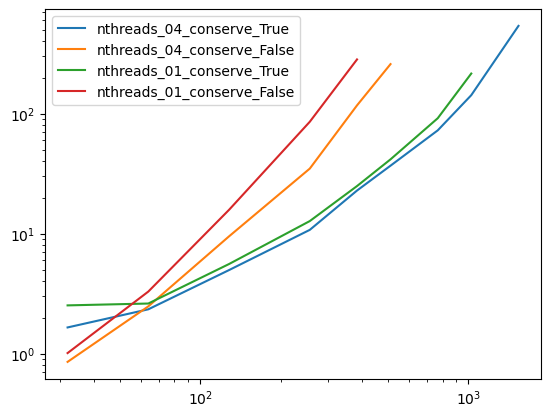

In [40]:

plt.figure()

for file in Path("../itensor/").glob("timings*.out"):
    chis, times = read_itensor_output(file)
    print(file.name)
    print(chis, times)
    plt.plot(chis, times, label=file.name[8:-4])
plt.loglog()
plt.legend()

    

timings_nthreads_1_conserve_False.txt
[ 32  64 128 256 384 512 768] [8.450000e-01 3.659000e+00 1.395600e+01 8.368900e+01 2.400910e+02
 5.971350e+02 2.550708e+03]
timings_nthreads_1_conserve_True.txt
[  32   64  128  256  384  512  768 1024 1536 2028] [1.876000e+00 2.596000e+00 5.075000e+00 1.235700e+01 2.383800e+01
 4.068800e+01 1.038820e+02 2.264000e+02 8.882820e+02 1.962583e+03]
timings_nthreads_4_conserve_False.txt
[ 32  64 128 256 384 512 768] [8.710000e-01 3.476000e+00 1.069300e+01 4.822600e+01 1.240710e+02
 3.031920e+02 1.599575e+03]
timings_nthreads_4_conserve_True.txt
[  32   64  128  256  384  512  768 1024 1536 2028] [   2.064    2.73     5.573   12.457   22.175   35.385   75.711  163.616
  709.501 1639.851]


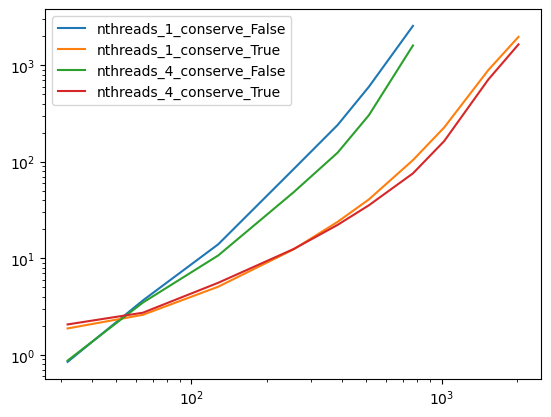

In [41]:

plt.figure()

for file in Path("../itensor/old").glob("timings*.txt"):
    chis, times = parse_itensor_output(file)
    print(file.name)
    print(chis, times)
    plt.plot(chis, times, label=file.name[8:-4])
plt.loglog()
plt.legend()
